In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import commonly used libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Import

In [5]:
import pandas as pd

# Load the training labels CSV
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Preview the data
print("First 5 rows:")
print(labels_df.head())

# Summary
print("\nSummary Info:")
print(labels_df.info())

print("\nLabel Distribution:")
print(labels_df['label'].value_counts())


First 5 rows:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Summary Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

Label Distribution:
label
0    130908
1     89117
Name: count, dtype: int64


## 1. Brief description of the problem and data

**Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.**
In this dataset, you are provided with a large number of small pathology images to classify.The goal is to automatically identify metastatic cancer in small image patches taken from lymph node biopsies. Each image is labeled as either:

*  1 – Tumor
*   0 – No Tumor
This is a binary classification task, where each input is a small color image, and the output is a label indicating the presence or absence of cancer cells.

This is a binary classification task, where each input is a small color image, and the output is a label indicating the presence or absence of cancer cells.

The dataset contains:

    1. Images (in train and test folders):

        Size: ~277,524 images in the train folder (may vary slightly by download version).

        Dimensions: Each image is 96×96×3 (RGB).

        Format: .tif images (high-quality image format used in medical imaging).

        The test set contains about 171,000 images for evaluation.

    2. Labels (train_labels.csv):

        Columns:

            id – Image file name (without .tif extension).

            label – 1 if the patch contains tumor tissue, 0 otherwise.

        Size: 1 row per image (≈277,524 rows).


## 1. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

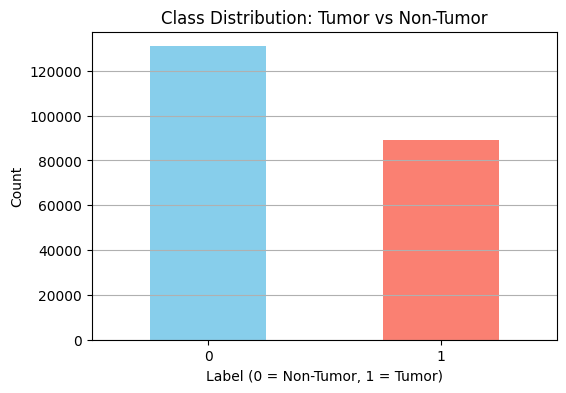

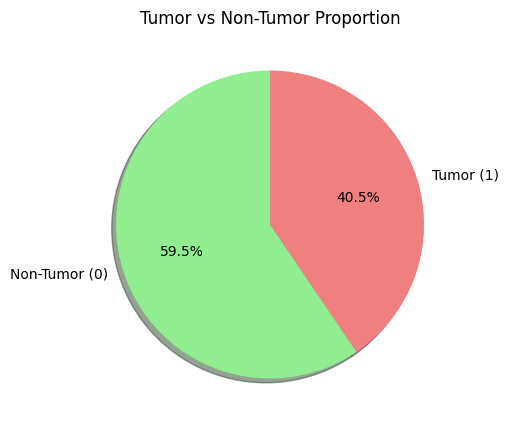

In [6]:
import matplotlib.pyplot as plt

# Bar plot
plt.figure(figsize=(6, 4))
labels_df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution: Tumor vs Non-Tumor')
plt.xlabel('Label (0 = Non-Tumor, 1 = Tumor)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Pie chart
plt.figure(figsize=(5, 5))
labels_df['label'].value_counts().plot(
    kind='pie', 
    autopct='%1.1f%%', 
    labels=['Non-Tumor (0)', 'Tumor (1)'],
    colors=['lightgreen', 'lightcoral'],
    startangle=90,
    shadow=True
)
plt.title('Tumor vs Non-Tumor Proportion')
plt.ylabel('')
plt.show()


Label 0 (No Cancer): ~130,000 images,Label 1 (Cancer): ~90,000 images.The dataset is imbalanced, with more non-cancerous patches than cancerous ones. This may bias a CNN model toward predicting class 0

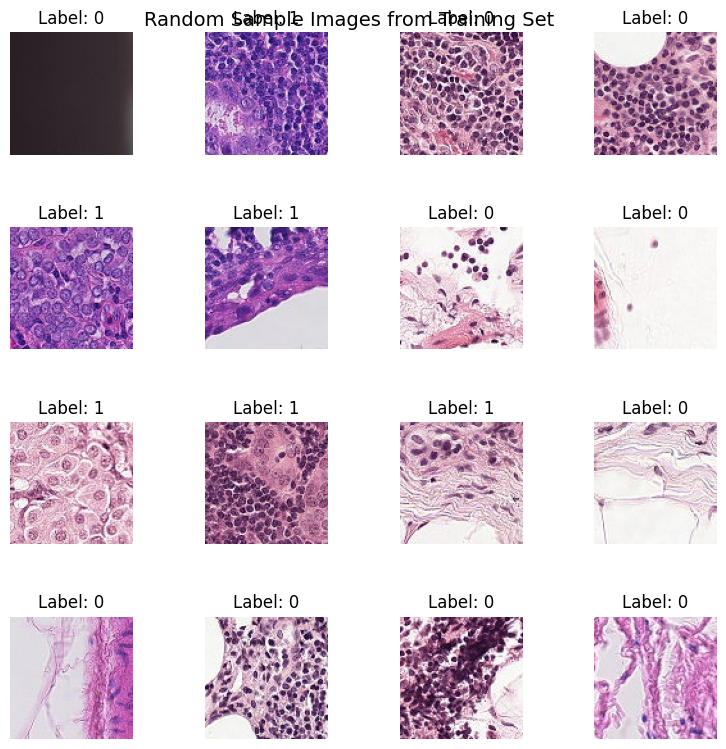

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to training images
train_images = '/kaggle/input/histopathologic-cancer-detection/train'

# Sample 16 random images
sample_images = labels_df.sample(16, random_state=42)

# Create 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout(pad=1.5)

# Loop and display each image
for i, ax in enumerate(axes.flat):
    img_id = sample_images.iloc[i]['id']
    label = sample_images.iloc[i]['label']
    
    # Add '.tif' extension
    img_path = os.path.join(train_images, img_id + '.tif')
    
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.suptitle("Random Sample Images from Training Set", fontsize=14)
plt.show()


100%|██████████| 3000/3000 [00:07<00:00, 417.07it/s]


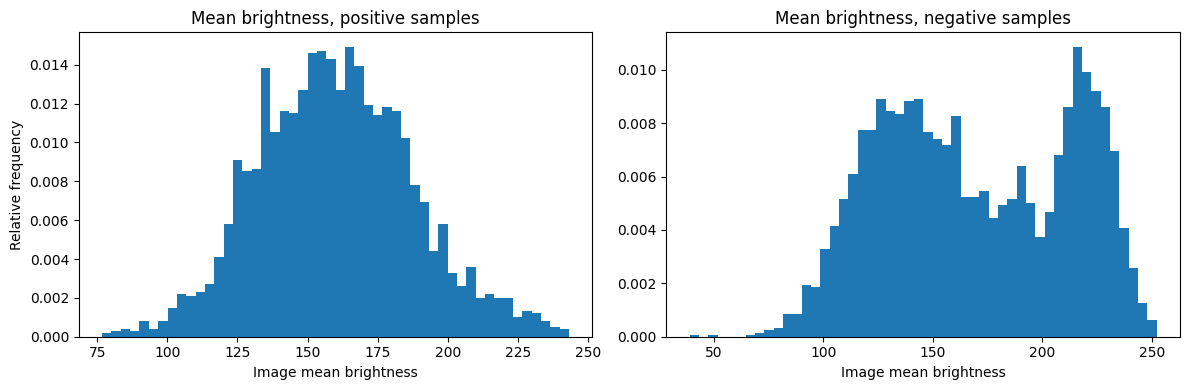

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Path to training images
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
IMAGE_SIZE = 96

# Initialize brightness lists
brightness_pos = []
brightness_neg = []

# Sample a subset to keep it fast (e.g., 3000 per class)
pos_samples = labels_df[labels_df['label'] == 1].sample(3000, random_state=1)
neg_samples = labels_df[labels_df['label'] == 0].sample(3000, random_state=1)

# Function to calculate mean brightness
def compute_mean_brightness(df, storage_list):
    for img_id in tqdm(df['id']):
        img_path = os.path.join(train_dir, img_id + '.tif')
        img = Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE))
        img_np = np.array(img)
        brightness = img_np.mean()
        storage_list.append(brightness)

# Compute for both classes
compute_mean_brightness(pos_samples, brightness_pos)
compute_mean_brightness(neg_samples, brightness_neg)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(brightness_pos, bins=50, density=True)
axes[0].set_title("Mean brightness, positive samples")
axes[0].set_xlabel("Image mean brightness")
axes[0].set_ylabel("Relative frequency")

axes[1].hist(brightness_neg, bins=50, density=True)
axes[1].set_title("Mean brightness, negative samples")
axes[1].set_xlabel("Image mean brightness")

plt.tight_layout()
plt.show()


From above plot we can see most pixel values are clustered between 230 and 255 for all three channels.There is sharp peak near the right end of the graphs suggesting the image is very bright.The actual cancerous/non-cancerous regions may occupy only a small area in the patch (darker/textured regions), so they could be hard to detect without enhancement.
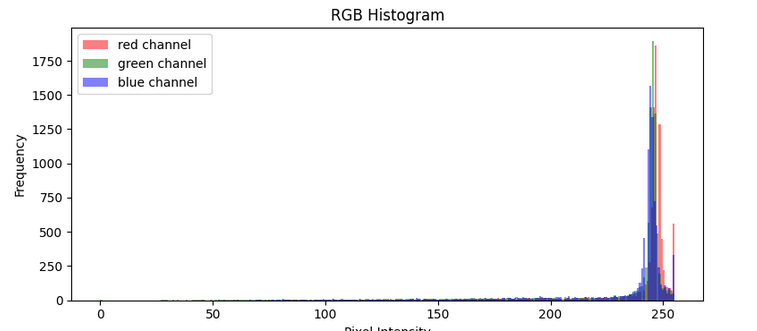

## Data PreProcessing

In [7]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Directory containing training images
image_dir = '/kaggle/input/histopathologic-cancer-detection/train'
IMAGE_SIZE = 96

# Load a subset (optional: to speed up initial tests)
sample_df = labels_df.sample(10000, random_state=42)  # or use entire labels_df
#sample_df = labels_df.copy()

X = []
y = []

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    img_id = row['id']
    label = row['label']
    
    img_path = os.path.join(image_dir, img_id + '.tif')
    img = Image.open(img_path).resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.array(img) / 255.0  # normalize to [0, 1]
    
    X.append(img_array)
    y.append(label)

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.uint8)

print(f"Image data shape: {X.shape}, Labels shape: {y.shape}")


100%|██████████| 30000/30000 [04:27<00:00, 112.09it/s]


Image data shape: (30000, 96, 96, 3), Labels shape: (30000,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")


Training samples: 24000
Validation samples: 6000


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

# No augmentation for validation data, just normalization
val_datagen = ImageDataGenerator()

# Create generators
train_data = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

val_data = val_datagen.flow(
    X_val, y_val,
    batch_size=32,
    shuffle=False
)


## 3. Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Model parameters (can tune later)
input_shape = (96, 96, 3)
learning_rate = 1e-4
dropout_conv = 0.3
dropout_dense = 0.4

# Build the model
model_cnn = Sequential()

# Block 1
model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(dropout_conv))

# Block 2
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(dropout_conv))

# Block 3
model_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Dropout(dropout_conv))

# Classification head
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(dropout_dense))
model_cnn.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model_cnn.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show summary
model_cnn.summary()


I0000 00:00:1749065151.999670      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 96, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,007,009 (19.10 MB)

 Trainable params: 5,006,561 (19.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss')
]


In [12]:
history = model_cnn.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15


I0000 00:00:1749065166.323284      97 service.cc:148] XLA service 0x782384003c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749065166.324033      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749065166.924833      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/750 ━━━━━━━━━━━━━━━━━━━━ 37s 51ms/step - accuracy: 0.5059 - loss: 2.2389 

I0000 00:00:1749065172.983612      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.7354 - loss: 0.6399 - val_accuracy: 0.5850 - val_loss: 0.8163
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.8041 - loss: 0.4355 - val_accuracy: 0.7748 - val_loss: 0.4964
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - accuracy: 0.8306 - loss: 0.4018 - val_accuracy: 0.7403 - val_loss: 0.5103
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 51s 67ms/step - accuracy: 0.8368 - loss: 0.3848 - val_accuracy: 0.8062 - val_loss: 0.4057
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 66ms/step - accuracy: 0.8421 - loss: 0.3618 - val_accuracy: 0.7008 - val_loss: 0.6126
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - accuracy: 0.8441 - loss: 0.3667 - val_accuracy: 0.6640 - val_loss: 0.6969
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 50s 67ms/step - accuracy: 0.8525 - loss: 0.3487 - val_accuracy: 0.6500 - val_loss: 0.7494
Epoch 8/15
678/750 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8619 - loss: 0.3292

KeyboardInterrupt: 

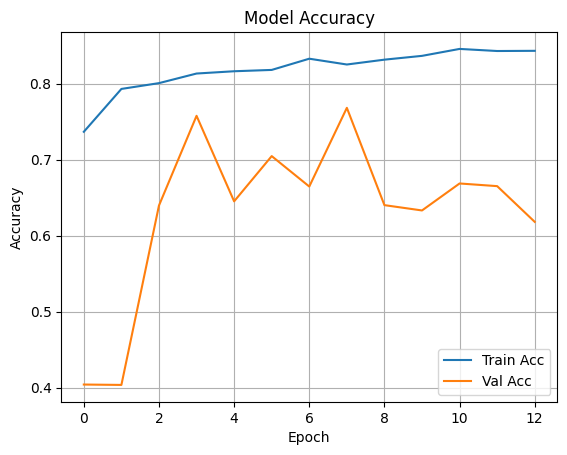

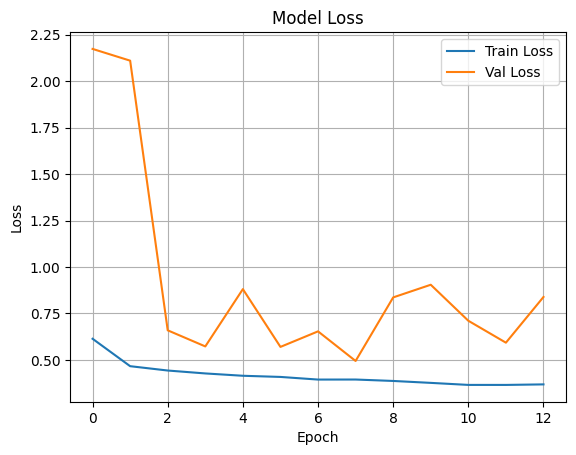

In [16]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
